<a href="https://colab.research.google.com/github/gnodking7/WDAnepv/blob/main/Example5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective
In this example, we use Synthetic dataset to illustrate the scalibility of WDA-nepv with respect to subspace dimension $p$, with respect to data dimension $d$, and with respect to number of data points $n$.

We will go over the background of the example in the following order:
1.   What is Synthetic dataset?
2.   What is WDA-nepv?
3.   Example Setup

### What is Synthetic dataset?
Synthetic dataset consists of three classes whose data matrices are:
$$\mathbf{X}^1\in\mathbb{R}^{d\times n_1},\quad \mathbf{X}^2\in\mathbb{R}^{d\times n_2},\quad \mathbf{X}^3\in\mathbb{R}^{d\times n_3}$$
The dataset is generated such that the first two components of the data points are centered around the coordinates $(-5,0)$ and $(5,0)$ for Class 1, centered around the coordinates $(-3,3)$ and $(3,-3)$ for Class 2, and centered around the coordinates $(-3,-3)$ and $(3,3)$ for Class 3. These first two components are randomly drawn at their corresponding centers using a Guassian distribution with a standard deviation of 0.5, and the number of data points for each class are equally split among its two clusters. The rest of $d-2$ components are drawn from the standard normal distribution. Finally, the dataset is standardized.

### What is WDA-nepv?

WDA-nepv is a simple iterative algorithm that solves Wasserstein Discriminant Analysis (WDA) [1]:
$$\max_{\mathbf{P}^T\mathbf{P}=I_p}\frac{\mbox{tr}(\mathbf{P}^T\mathbf{C}_b(\mathbf{P})\mathbf{P})}{\mbox{tr}(\mathbf{P}^T\mathbf{C}_w(\mathbf{P})\mathbf{P})}$$
where $\mathbf{C}_b(\mathbf{P})$ and $\mathbf{C}_w(\mathbf{P})$
are defined as the between and within cross-covariance matrices
$$\mathbf{C}_b(\mathbf{P}_k) = \sum_{c,c'>c}  \sum_{ij}{T}_{ij}^{c,c'}(\mathbf{P}_k)(\mathbf{x}_i^c-\mathbf{x}_j^{c'})(\mathbf{x}_i^c-\mathbf{x}_j^{c'})^T$$
$$\mathbf{C}_w(\mathbf{P}_k) = \sum_c  \sum_{ij}{T}_{ij}^{c,c}(\mathbf{P}_k)(\mathbf{x}_i^c-\mathbf{x}_j^{c})(\mathbf{x}_i^c-\mathbf{x}_j^{c})^T $$
The matrices $\mathbf{T}^{c,c'}$ and $\mathbf{T}^{c,c}$ are transport matrices and can be computed using Acc_SK. See Example 1 for the discussion of transport matrices and Acc_SK.

In a nutshell, WDA-nepv can be described as an algorithm that iteratively updates the projection matrix $\mathbf{P}_k$ by 
$$\mathbf{P}_{k+1} = \mbox{argmax}_{\mathbf{P}^T\mathbf{P}=I_p}
\frac{\mbox{tr}(\mathbf{P}^T\mathbf{C}_b(\mathbf{P}_k)\mathbf{P})}
{\mbox{tr}(\mathbf{P}^T\mathbf{C}_w(\mathbf{P}_k)\mathbf{P})}$$
which, as a standard trace ratio problem, can be solved by the Self-Consistent-Field (SCF) method [2].

### Example Setup

We investigate two different scenarios:



*   Fix the data point dimension to $d=10$. We report the scalability on the increasing subspace dimension $p=1,2,3,4,5$ for three different regularization parameters $\lambda=0.1,0.01,0.001$.
*   Fix the subspace dimension to $p=2$. We report the scalability on the increasing dimension $d=10,20,40,80,160,320,640,1280,2560$ for three different regularization parameters $\lambda=0.1,0.01,0.001$. The perturbation term $\epsilon I_d$ for $\epsilon=10$ is added to the matrix $\mathbf{C}_w(\mathbf{P})$ to ensure its positive definiteness and to speed up the computation speed. 

Initial projection matrix $\mathbf{P}_0$ is randomly chosen. All results are averaged over 100 trials.

### Scenario 1

In [1]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

In [2]:
import WDA_datasets as datasets
import WDAnepv
import numpy as np
import matplotlib.pylab as pl
import time

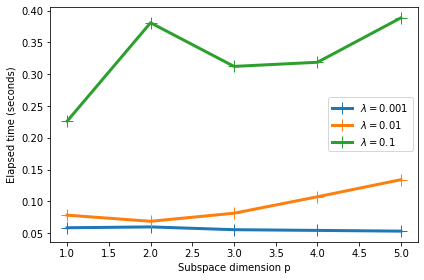

In [7]:
# Run
Time1, Time2, Time3 = [], [], []  # to store for various reg param
n_trials = 100

# trials
for i in range(n_trials):
  # load Synthetic dataset
  TR, TR_L, TST, TST_L = datasets.load_synth(10, 100, 100)
  for reg in [0.001, 0.01, 0.1]:
    Time = [] # to store for various p
    for p in [1, 2, 3, 4, 5]:
      x0 = np.random.randn(10, p)
      P0, r = np.linalg.qr(x0) # random initial projection
      start = time.time()
      Popt, proj, WDA_Val, PROJ, Sub_Err = WDAnepv.wda_nepv(TR, TR_L, p, reg, P0, tol=1e-3)
      end = time.time()
      Time.append(end - start)
    if reg == 0.001:
      Time1.append(Time)
    elif reg == 0.01:
      Time2.append(Time)
    elif reg == 0.1:
      Time3.append(Time)

# averages
Avg_Time1 = np.mean(Time1, 0) # for reg param 0.001
Avg_Time2 = np.mean(Time2, 0) # for reg param 0.01
Avg_Time3 = np.mean(Time3, 0) # for reg param 0.1

# Plot
pl.plot([1,2,3,4,5], Avg_Time1, '+-', linewidth=3, markersize=12, label='$\lambda=0.001$')
pl.plot([1,2,3,4,5], Avg_Time2, '+-', linewidth=3, markersize=12, label='$\lambda=0.01$')
pl.plot([1,2,3,4,5], Avg_Time3, '+-', linewidth=3, markersize=12, label='$\lambda=0.1$')
pl.legend()
pl.xlabel('Subspace dimension p')
pl.ylabel('Elapsed time (seconds)')
pl.tight_layout()

### Scenario 2

In [5]:
# Run
Time1, Time2, Time3 = [], [], []  # to store for various reg param
n_trials = 100

# trials
for i in range(n_trials):
  for reg in [0.001, 0.01, 0.1]:
    Time = [] # to store for various d
    for d in [80, 160, 320, 640, 1280, 2560]:
      # load Synthetic dataset
      TR, TR_L, TST, TST_L = datasets.load_synth(d, 100, 100)
      x0 = np.random.randn(d, 2)
      P0, r = np.linalg.qr(x0) # random initial projection
      start = time.time()
      Popt, proj, WDA_Val, PROJ, Sub_Err = WDAnepv.wda_nepv(TR, TR_L, 2, reg, P0, Breg=0.1, tol=1e-3)
      end = time.time()
      Time.append(end - start)
    if reg == 0.001:
      Time1.append(Time)
    elif reg == 0.01:
      Time2.append(Time)
    elif reg == 0.1:
      Time3.append(Time)

# averages
Avg_Time1 = np.mean(Time1, 0) # for reg param 0.001
Avg_Time2 = np.mean(Time2, 0) # for reg param 0.01
Avg_Time3 = np.mean(Time3, 0) # for reg param 0.1

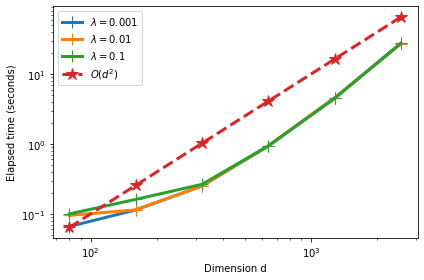

In [6]:
# Plot
pl.loglog([80, 160, 320, 640, 1280, 2560], Avg_Time1, '+-', linewidth=3, markersize=12, label='$\lambda=0.001$')
pl.loglog([80, 160, 320, 640, 1280, 2560], Avg_Time2, '+-', linewidth=3, markersize=12, label='$\lambda=0.01$')
pl.loglog([80, 160, 320, 640, 1280, 2560], Avg_Time3, '+-', linewidth=3, markersize=12, label='$\lambda=0.1$')
pl.loglog([80, 160, 320, 640, 1280, 2560], (10 ** (-5)) * np.array([80, 160, 320, 640, 1280, 2560]) ** 2, '*--', linewidth=3, markersize=12, label='$O(d^2)$')
pl.legend()
pl.xlabel('Dimension d')
pl.ylabel('Elapsed time (seconds)')
pl.tight_layout()

In [ ]:
# Run
Time1, Time2, Time3 = [], [], []  # to store for various reg param
n_trials = 100

# trials
for i in range(n_trials):
    for reg in [0.001, 0.01, 0.1]:
        Time = [] # to store for various d
        for n in [100, 200, 300, 500, 800, 1000]:
            # load Synthetic dataset
            TR, TR_L, TST, TST_L = datasets.load_synth(50, n, 100)
            x0 = np.random.randn(50, 2)
            P0, r = np.linalg.qr(x0) # random initial projection
            start = time.time()
            Popt, proj, WDA_Val, PROJ, Sub_Err = WDAnepv.wda_nepv(TR, TR_L, 2, reg, P0, tol=1e-3)
            end = time.time()
            Time.append(end - start)
        if reg == 0.001:
            Time1.append(Time)
        elif reg == 0.01:
            Time2.append(Time)
        elif reg == 0.1:
            Time3.append(Time)
        
# averages
Avg_Time1 = np.mean(Time1, 0) # for reg param 0.001
Avg_Time2 = np.mean(Time2, 0) # for reg param 0.01
Avg_Time3 = np.mean(Time3, 0) # for reg param 0.1

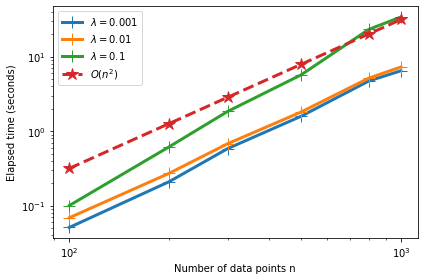

In [4]:
pl.loglog([100, 200, 300, 500, 800, 1000], Avg_Time1, '+-', linewidth=3, markersize=12, label='$\lambda=0.001$')
pl.loglog([100, 200, 300, 500, 800, 1000], Avg_Time2, '+-', linewidth=3, markersize=12, label='$\lambda=0.01$')
pl.loglog([100, 200, 300, 500, 800, 1000], Avg_Time3, '+-', linewidth=3, markersize=12, label='$\lambda=0.1$')
pl.loglog([100, 200, 300, 500, 800, 1000], (10 ** (-4.5)) * np.array([100, 200, 300, 500, 800, 1000]) ** 2, '*--', linewidth=3, markersize=12, label='$O(n^2)$')
pl.legend()
pl.xlabel('Number of data points n')
pl.ylabel('Elapsed time (seconds)')
pl.tight_layout()

# References

[1] R ́emi Flamary, Marco Cuturi, Nicolas Courty, and Alain Rakotomamonjy. Wasserstein dis-
criminant analysis. Machine Learning, 107(12):1923–1945, 2018.

[2] Lei-Hong Zhang, Li-Zhi Liao, and Michael K Ng. Fast algorithms for the generalized foley–
sammon discriminant analysis. SIAM journal on matrix analysis and applications, 31(4):1584–
1605, 2010.